## importing library manually

In [1]:
class FuzzyClause():
	'''
	A fuzzy clause of the type 'variable is set'
	used in fuzzy IF ... THEN ... rules
	clauses can be antecedent (if part) or consequent 
	(then part)
	'''

	def __init__(self, variable, f_set, degree=1):
		'''
		initialization of the fuzzy clause

		Arguments:
		----------
		variable -- the clause variable in 'variable is set'
		set -- the clause set in 'variable is set'
		'''

		if f_set is None:
			raise Exception('set none')

		if f_set.name == '':
			raise Exception(str(f_set), 'no set name')


		self._variable = variable
		self._set = f_set

	def __str__(self):
		'''
		string representation of the clause.

		Returns:
		--------
		str: str, string representation of the clause in the form
					A is x
		'''
		return f'{self._variable.name} is {self._set.name}'

	@property
	def variable_name(self):
		'''
		returns the name of the clause variable

		Returns:
		--------
		variable_name: str, name of variable
		'''
		return self._variable.name

	@property
	def set_name(self):
		'''
		returns the name of the clause variable

		Returns:
		--------
		variable_name: str, name of variable
		'''
		return self._set.name

	def evaluate_antecedent(self):
		'''
		Used when set is antecedent.
		returns the set degree of membership.

		Returns:
		--------
		dom -- number, the set degree of membership given a value for
				that variable. This value is determined at an earlier stage
				and stored in the set
		'''
		return self._set.last_dom_value

	def evaluate_consequent(self, dom):
		'''
		Used when clause is consequent.

		Arguments:
		-----------
		dom -- number, scalar value from the antecedent clauses

		Returns:
		--------
		set -- Type1FuzzySet, a set resulting from min operation with
				the scalar value
		'''
		self._variable.add_rule_contribution(self._set.min_scalar(dom))

In [2]:
# from .fuzzy_clause import FuzzyClause

class FuzzyRule():
	'''
	A fuzzy rule of the type
	IF [antecedent clauses] THEN [consequent clauses]
	'''

	def __init__(self):
		'''
		initializes the rule. Two data structures are necessary:
			Antecedent clauses list
			consequent clauses list
		'''
		self._antecedent = []
		self._consequent = []

	def __str__(self):
		'''
		string representation of the rule.

		Returns:
		--------
		str: str, string representation of the rule in the form
					IF [antecedent clauses] THEN [consequent clauses]
		'''
		ante = ' and '.join(map(str, self._antecedent))
		cons = ' and '.join(map(str, self._consequent))
		return f'If {ante} then {cons}'

	def add_antecedent_clause(self, var, f_set):
		'''
		adds an antecedent clause to the rule

		Arguments:
		-----------
			clause -- FuzzyClause, the antecedent clause
		'''
		self._antecedent.append(FuzzyClause(var, f_set))

	def add_consequent_clause(self, var, f_set):
		'''
		adds an consequent clause to the rule

		Arguments:
		-----------
			clause -- FuzzyClause, the consequent clause
		'''
		self._consequent.append(FuzzyClause(var, f_set))

	def evaluate(self):
		'''
		evaluation of the rule.
		the antecedent clauses are executed and the minimum degree of
		membership is retained.
		This is used in teh consequent clauses to min with the consequent
		set
		The values are returned in a dict of the form {variable_name: scalar min set, ...}

		Returns:
		--------
		rule_consequence -- dict, the resulting sets in the form
							{variable_name: scalar min set, ...}
		'''
		# rule dom initialize to 1 as min operator will be performed
		rule_strength = 1

		# execute all antecedent clauses, keeping the minimum of the
		# returned doms to determine the rule strength
		for ante_clause in self._antecedent:
			rule_strength = min(ante_clause.evaluate_antecedent(), rule_strength)

		# execute consequent clauses, each output variable will update its output_distribution set
		for consequent_clause in self._consequent:
			consequent_clause.evaluate_consequent(rule_strength)

	def evaluate_info(self):
		'''
		evaluation of the rule.
		the antecedent clauses are executed and the minimum degree of
		membership is retained.
		This is used in teh consequent clauses to min with the consequent
		set
		The values are returned in a dict of the form {variable_name: scalar min set, ...}

		Returns:
		--------
		rule_consequence -- dict, the resulting sets in the form
							{variable_name: scalar min set, ...}
		'''
		# rule dom initialize to 1 as min operator will be performed
		rule_strength = 1

		
		# execute all antecedent clauses, keeping the minimum of the
		# returned doms to determine the rule strength
		for ante_clause in self._antecedent:
			rule_strength = min(ante_clause.evaluate_antecedent(), rule_strength)

		# execute consequent clauses, each output variable will update its output_distribution set
		for consequent_clause in self._consequent:
			consequent_clause.evaluate_consequent(rule_strength)

		return f'{rule_strength} : {self}'

False
True


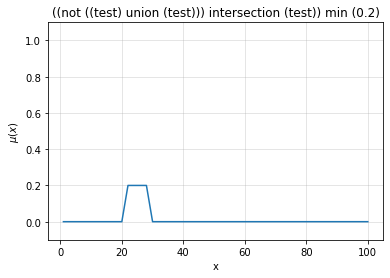

45.83325


In [5]:
import numpy as np
import copy
import matplotlib.pyplot as plt


class FuzzySet:

	_precision: int = 3

	def __init__(self, name, domain_min, domain_max, res):
		
		self._domain_min = domain_min
		self._domain_max = domain_max
		self._res = res

		self._domain = np.linspace(domain_min, domain_max, res)
		self._dom = np.zeros(self._domain.shape)
		self._name = name
		self._last_dom_value = 0

	def __getitem__(self, x_val):
		return self._dom[np.abs(self._domain-x_val).argmin()]

	def __setitem__(self, x_val, dom):
		self._dom[np.abs(self._domain-x_val).argmin()] = round(dom, self._precision)

	def __str__(self):
		return ' + '.join([str(a) + '/' + str(b) for a,b in zip(self._dom, self._domain)])

	def __get_last_dom_value(self):
		return self._last_dom_value

	def __set_last_dom_value(self, d):
		self._last_dom_value = d

	last_dom_value = property(__get_last_dom_value, __set_last_dom_value)

	@property
	def name(self):
		return self._name

	@property
	def empty(self):
		return np.all(self._dom == 0)

	@property
	def name(self):
		return self._name

	@classmethod
	def create_trapezoidal(cls, name, domain_min, domain_max, res, a, b, c, d):
		t1fs = cls(name, domain_min, domain_max, res)

		a = t1fs._adjust_domain_val(a)
		b = t1fs._adjust_domain_val(b)
		c = t1fs._adjust_domain_val(c)
		d = t1fs._adjust_domain_val(d)

		t1fs._dom = np.round(np.minimum(np.maximum(np.minimum((t1fs._domain-a)/(b-a), (d-t1fs._domain)/(d-c)), 0), 1), t1fs._precision)
		return t1fs

	@classmethod
	def create_triangular(cls, name, domain_min, domain_max, res, a, b, c):
		t1fs = cls(name, domain_min, domain_max, res)

		a = t1fs._adjust_domain_val(a)
		b = t1fs._adjust_domain_val(b)
		c = t1fs._adjust_domain_val(c)

		if b == a:
			t1fs._dom = np.round(np.maximum((c-t1fs._domain)/(c-b), 0), t1fs._precision)
		elif b == c:
			t1fs._dom = np.round(np.maximum((t1fs._domain-a)/(b-a), 0), t1fs._precision)
		else:
			t1fs._dom = np.round(np.maximum(np.minimum((t1fs._domain-a)/(b-a), (c-t1fs._domain)/(c-b)), 0), t1fs._precision)
		
		return t1fs

	def _adjust_domain_val(self, x_val):
		return self._domain[np.abs(self._domain-x_val).argmin()]

	def clear_set(self):
		self._dom.fill(0)

	def min_scalar(self, val):
		
		result = FuzzySet(f'({self._name}) min ({val})', self._domain_min, self._domain_max, self._res)
		result._dom = np.minimum(self._dom, val)

		return result

	def union(self, f_set):

		result = FuzzySet(f'({self._name}) union ({f_set._name})', self._domain_min, self._domain_max, self._res)
		result._dom = np.maximum(self._dom, f_set._dom)

		return result

	def intersection(self, f_set):

		result = FuzzySet(f'({self._name}) intersection ({f_set._name})', self._domain_min, self._domain_max, self._res)
		result._dom = np.minimum(self._dom, f_set._dom)

		return result

	def complement(self):

		result = FuzzySet(f'not ({self._name})', self._domain_min, self._domain_max, self._res)
		result._dom = 1 - self._dom

		return result

	def cog_defuzzify(self):
		
		num = np.sum(np.multiply(self._dom, self._domain))
		den = np.sum(self._dom)

		return num/den

	def domain_elements(self):
		return self._domain

	def dom_elements(self):
		return self._dom

	def plot_set(self, ax, col=''):
		ax.plot(self._domain, self._dom, col)
		ax.set_ylim([-0.1,1.1])
		ax.set_title(self._name)
		ax.grid(True, which='both', alpha=0.4)
		ax.set(xlabel='x', ylabel='$\mu(x)$')

if __name__ == "__main__":
	s = FuzzySet.create_trapezoidal('test', 1, 100, 100, 20, 30, 50, 80)

	print(s.empty)

	u = FuzzySet('u', 1, 100, 100)

	print(u.empty)

	t = FuzzySet.create_trapezoidal('test', 1, 100, 100, 30, 50, 90, 100)

	fig, axs = plt.subplots(1, 1)

	s.union(t).complement().intersection(s).min_scalar(0.2).plot_set(axs)

	plt.show()
	print(s.cog_defuzzify())


In [6]:
# from .fuzzy_rule import FuzzyRule
# from fuzzy_system.fuzzy_variable_output import FuzzyOutputVariable
# from fuzzy_system.fuzzy_variable_input import FuzzyInputVariable

import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np

class FuzzySystem:
	'''
	A type-1 fuzzy system based on Mamdani inference system

	Reference:
	----------
	Mamdani, Ebrahim H., and Sedrak Assilian. 
	"An experiment in linguistic synthesis with a 
	fuzzy logic controller." Readings in Fuzzy Sets 
	for Intelligent Systems. Morgan Kaufmann, 1993. 283-289.
	'''

	def __init__(self):
		'''
		initializes fuzzy system.
		data structures required:
			input variables -- dict, having format {variable_name: FuzzyVariable, ...}
			output variables -- dict, having format {variable_name: FuzzyVariable, ...}
			rules -- list of FuzzyRule
			output_distribution -- dict holding fuzzy output for each variable having format
								{variable_name: FuzzySet, ...}
		'''
		self._input_variables = {}
		self._output_variables = {}
		self._rules = []

	def __str__(self):
		'''
		string representation of the system.

		Returns:
		--------
		str: str, string representation of the system in the form
				Input:
				input_variable_name(set_names)...
				Output:
				output_variable_name(set_names)...
				Rules:
				IF [antecedent clauses] THEN [consequent clauses]
		'''

		ret_str = 'Input: \n'
		for n, s in self._input_variables.items():
			ret_str = ret_str + f'{n}: ({s})\n'

		ret_str = ret_str + 'Output: \n'
		for n, s in self._output_variables.items():
			ret_str = ret_str + f'{n}: ({s})\n'

		ret_str = ret_str + 'Rules: \n'
		for rule in self._rules:
			ret_str = ret_str + f'{rule}\n'

		return ret_str

	def add_input_variable(self, variable):
		'''
		adds an input variable to the system

		Arguments:
		----------
		variable -- FuzzyVariable, the input variable
		'''
		self._input_variables[variable.name] = variable

	def add_output_variable(self, variable):
		self._output_variables[variable.name] = variable


	def get_input_variable(self, name):
		'''
		get an input variable given the name

		Arguments:
		-----------
		name -- str, name of variable

		Returns:
		--------
		variable -- FuzzyVariable, the input variable
		'''
		return self._input_variables[name]

	def get_output_variable(self, name):
		'''
		get an output variable given the name

		Arguments:
		-----------
		name -- str, name of variable

		Returns:
		--------
		variable -- FuzzyVariable, the output variable
		'''

		return self._output_variables[name]

	def _clear_output_distributions(self):
		'''
		used for each iteration. The fuzzy result is cleared
		'''
		map(lambda output_var: output_var.clear_output_distribution(), self._output_variables.values())

	def add_rule(self, antecedent_clauses, consequent_clauses):
		'''
		adds a new rule to the system.
		TODO: add checks

		Arguments:
		-----------
		antecedent_clauses -- dict, having the form {variable_name:set_name, ...}
		consequent_clauses -- dict, having the form {variable_name:set_name, ...}
		'''
		# create a new rule
		# new_rule = FuzzyRule(antecedent_clauses, consequent_clauses)
		new_rule = FuzzyRule()

		for var_name, set_name in antecedent_clauses.items():
			# get variable by name
			var = self.get_input_variable(var_name)
			# get set by name
			f_set = var.get_set(set_name)
			# add clause
			new_rule.add_antecedent_clause(var, f_set)

		for var_name, set_name in consequent_clauses.items():
			var = self.get_output_variable(var_name)
			f_set = var.get_set(set_name)
			new_rule.add_consequent_clause(var, f_set)

		# add the new rule
		self._rules.append(new_rule)

	def evaluate_output(self, input_values):
		'''
		Executes the fuzzy inference system for a set of inputs

		Arguments:
		-----------
		input_values -- dict, containing the inputs to the systems in the form
							{input_variable_name: value, ...}

		Returns:
		--------
		output -- dict, containing the outputs from the systems in the form
					{output_variable_name: value, ...}
		'''
		# clear the fuzzy consequences as we are evaluating a new set of inputs.
		# can be optimized by comparing if the inputs have changes from the previous
		# iteration.
		self._clear_output_distributions()

		# Fuzzify the inputs. The degree of membership will be stored in
		# each set
		for input_name, input_value in input_values.items():
			self._input_variables[input_name].fuzzify(input_value)

		# evaluate rules
		for rule in self._rules:
			rule.evaluate()

		# finally, defuzzify all output distributions to get the crisp outputs
		output = {}
		for output_var_name, output_var in self._output_variables.items():
			output[output_var_name] = output_var.get_crisp_output()

		return output


	def evaluate_output_info(self, input_values):
		'''
		Executes the fuzzy inference system for a set of inputs

		Arguments:
		-----------
		input_values -- dict, containing the inputs to the systems in the form
							{input_variable_name: value, ...}

		Returns:
		--------
		output -- dict, containing the outputs from the systems in the form
					{output_variable_name: value, ...}
		'''
		info = {}
		# clear the fuzzy consequences as we are evaluating a new set of inputs.
		# can be optimized by comparing if the inputs have changes from the previous
		# iteration.
		self._clear_output_distributions()

		# Fuzzify the inputs. The degree of membership will be stored in
		# each set
		fuzzification_info = []
		for input_name, input_value in input_values.items():
			fuzzification_info.append(self._input_variables[input_name].fuzzify_info(input_value))

		info['fuzzification'] = '\n'.join(fuzzification_info)

		# evaluate rules
		rule_info = []
		for rule in self._rules:
			rule_info.append(rule.evaluate_info())

		info['rules'] = '\n'.join(rule_info)


		# finally, defuzzify all output distributions to get the crisp outputs
		output = {}
		for output_var_name, output_var in self._output_variables.items():
			output[output_var_name], info = output_var.get_crisp_output_info()
			# info[output_var_name] = info
		
		return output, info

	def plot_system(self):

		total_var_count = len(self._input_variables) + len(self._output_variables)
		if total_var_count <2:
			total_var_count = 2

		fig, axs = plt.subplots(total_var_count, 1)

		fig.tight_layout(pad=1.0)

		for idx, var_name in enumerate(self._input_variables):
			self._input_variables[var_name].plot_variable(ax=axs[idx], show=False)

		for idx, var_name in enumerate(self._output_variables):
			self._output_variables[var_name].plot_variable(ax=axs[len(self._input_variables)+idx], show=False)
		plt.figure(figsize=(15,10))
		plt.show()

if __name__ == "__main__":
	pass

In [7]:
# from .fuzzy_set import FuzzySet
import matplotlib.pyplot as plt
import numpy as np

class FuzzyVariable():
	'''
	A type-1 fuzzy variable that is mage up of a number of type-1 fuzzy sets
	'''
	def __init__(self, name, min_val, max_val, res):
		'''
		creates a new type-1 fuzzy variable (universe)

		Arguments:
		----------
			min_val -- number, minimum value of variable
			max_val -- number, maximum value of variable
			res -- int, resolution of variable
		'''
		self._sets={}
		self._max_val = max_val
		self._min_val = min_val
		self._res = res
		self._name = name

	def __str__(self):
		return ', '.join(self._sets.keys())

	@property
	def name(self):
		return self._name

	def _add_set(self, name, f_set):
		'''
		adds a fuzzy set to the variable

		Arguments:
		----------
			name -- string, name of the set
			f_set -- FuzzySet, The set
		'''
		self._sets[name] = f_set

	def get_set(self, name):
		'''
		returns a set given the name
		Arguments:
		----------
		name -- str, set name

		Returns:
		--------
		set -- FuzzySet, the set
		'''
		return self._sets[name]

	def add_triangular(self, name, low, mid, high):
		new_set = FuzzySet.create_triangular(name, self._min_val, self._max_val, self._res, low, mid, high)
		self._add_set(name, new_set)
		return new_set

	def add_trapezoidal(self, name, a, b, c, d):
		new_set = FuzzySet. create_trapezoidal(name, self._min_val, self._max_val, self._res, a, b, c, d)
		self._add_set(name, new_set)
		return new_set

	def plot_variable(self, ax=None, show=True):
		'''
		plots a graphical representation of the fuzzy variable

		Reference:
		----------
			https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
		'''
		if ax == None:
			ax = plt.subplot(111)
			ax = plt.figure(figsize=(15,10))

		for n ,s in self._sets.items():
			ax.plot(s.domain_elements(), s.dom_elements(), label=n)
# 			ax.figure(figsize=(15,10))

		# Shrink current axis by 20%
		pos = ax.get_position()
		ax.set_position([pos.x0, pos.y0, pos.width * 0.8, pos.height])
		ax.grid(True, which='both', alpha=0.4)
		ax.set_title(self._name)
		ax.set(xlabel='x', ylabel='$\mu (x)$')


		# Put a legend to the right of the current axis
		ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

		if show:

			plt.show()


In [8]:
# from .fuzzy_variable import FuzzyVariable

class FuzzyInputVariable(FuzzyVariable):

	def __init__(self, name, min_val, max_val, res):
		super().__init__(name, min_val, max_val, res)

	def fuzzify(self, value):
		'''
		performs fuzzification of the variable. used when the
		variable is an input one

		Arguments:
		-----------
		value -- number, input value for the variable

		'''
		# get dom for each set and store it - it will be required for each rule
		for set_name, f_set in self._sets.items():
			f_set.last_dom_value = f_set[value]

	def fuzzify_info(self, value):
		'''
		performs fuzzification of the variable. used when the
		variable is an input one

		Arguments:
		-----------
		value -- number, input value for the variable

		'''
		# get dom for each set and store it - it will be required for each rule
		for set_name, f_set in self._sets.items():
			f_set.last_dom_value = f_set[value]

		res = []

		res.append(self._name)
		res.append('\n')

		for _, f_set in self._sets.items():
			res.append(f_set.name)
			res.append(str(f_set.last_dom_value))
			res.append('\n')

		return ' '.join(res)


if __name__ == "__main__":
	pass

In [9]:
# from .fuzzy_variable import FuzzyVariable
# from .fuzzy_set import FuzzySet

class FuzzyOutputVariable(FuzzyVariable):

    def __init__(self, name, min_val, max_val, res):
        super().__init__(name, min_val, max_val, res)
        self._output_distribution = FuzzySet(name, min_val, max_val, res)

    def clear_output_distribution(self):
        self._output_distribution.clear_set()

    def add_rule_contribution(self, rule_consequence):
        self._output_distribution = self._output_distribution.union(rule_consequence)

    def get_crisp_output(self):
        return self._output_distribution.cog_defuzzify()

    def get_crisp_output_info(self):
        return self._output_distribution.cog_defuzzify(), self._output_distribution


if __name__ == "__main__":
    pass

## driver code

In [10]:
# from fuzzy_system.fuzzy_variable_output import FuzzyOutputVariable
# from fuzzy_system.fuzzy_variable_input import FuzzyInputVariable
# # from fuzzy_system.fuzzy_variable import FuzzyVariable
# from fuzzy_system.fuzzy_system import FuzzySystem

temp = FuzzyInputVariable('Temperature', 10, 40, 100)
temp.add_triangular('Cold', 10, 10, 25)
temp.add_triangular('Medium', 15, 25, 35)
temp.add_triangular('Hot', 25, 40, 40)

humidity = FuzzyInputVariable('Humidity', 20, 100, 100)
humidity.add_triangular('Wet', 20, 20, 60)
humidity.add_trapezoidal('Normal', 30, 50, 70, 90)
humidity.add_triangular('Dry', 60, 100, 100)

motor_speed = FuzzyOutputVariable('Speed', 0, 100, 100)
motor_speed.add_triangular('Slow', 0, 0, 50)
motor_speed.add_triangular('Moderate', 10, 50, 90)
motor_speed.add_triangular('Fast', 50, 100, 100)

system = FuzzySystem()
system.add_input_variable(temp)
system.add_input_variable(humidity)
system.add_output_variable(motor_speed)

system.add_rule(
		{ 'Temperature':'Cold',
			'Humidity':'Wet' },
		{ 'Speed':'Slow'})

system.add_rule(
		{ 'Temperature':'Cold',
			'Humidity':'Normal' },
		{ 'Speed':'Slow'})

system.add_rule(
		{ 'Temperature':'Medium',
			'Humidity':'Wet' },
		{ 'Speed':'Slow'})

system.add_rule(
		{ 'Temperature':'Medium',
			'Humidity':'Normal' },
		{ 'Speed':'Moderate'})

system.add_rule(
		{ 'Temperature':'Cold',
			'Humidity':'Dry' },
		{ 'Speed':'Moderate'})

system.add_rule(
		{ 'Temperature':'Hot',
			'Humidity':'Wet' },
		{ 'Speed':'Moderate'})

system.add_rule(
		{ 'Temperature':'Hot',
			'Humidity':'Normal' },
		{ 'Speed':'Fast'})

system.add_rule(
		{ 'Temperature':'Hot',
			'Humidity':'Dry' },
		{ 'Speed':'Fast'})

system.add_rule(
		{ 'Temperature':'Medium',
			'Humidity':'Dry' },
		{ 'Speed':'Fast'})



{'Speed': 37.24647662394699}


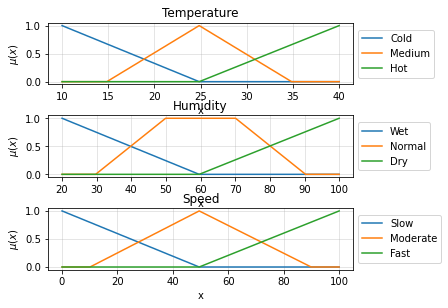

<Figure size 1080x720 with 0 Axes>

In [11]:
output = system.evaluate_output({
				'Temperature':18,
				'Humidity':60
		})

print(output)
# print('fuzzification\n-------------\n', info['fuzzification'])
# print('rules\n-----\n', info['rules'])

system.plot_system()


In [12]:
# from fuzzy_system.fuzzy_variable_output import FuzzyOutputVariable
# from fuzzy_system.fuzzy_variable_input import FuzzyInputVariable
# from fuzzy_system.fuzzy_system import FuzzySystem

x1 = FuzzyInputVariable('x1', 0, 100, 100)
x1.add_triangular('S', 0, 25, 50)
x1.add_triangular('M', 25, 50, 75)
x1.add_triangular('L', 50, 75, 100)

x2 = FuzzyInputVariable('x2', 0, 100, 100)
x2.add_triangular('S', 0, 25, 50)
x2.add_triangular('M', 25, 50, 75)
x2.add_triangular('L', 50, 75, 100)

y = FuzzyOutputVariable('y', 0, 100, 100)
y.add_triangular('S', 0, 25, 50)
y.add_triangular('M', 25, 50, 75)
y.add_triangular('L', 50, 75, 100)

z = FuzzyOutputVariable('z', 0, 100, 100)
z.add_triangular('S', 0, 25, 50)
z.add_triangular('M', 25, 50, 75)
z.add_triangular('L', 50, 75, 100)

system = FuzzySystem()
system.add_input_variable(x1)
system.add_input_variable(x2)
system.add_output_variable(y)
system.add_output_variable(z)

system.add_rule(
		{ 'x1':'S',
			'x2':'S' },
		{ 'y':'S',
			'z':'L' })

system.add_rule(
		{ 'x1':'M',
			'x2':'M' },
		{ 'y':'M',
			'z':'M' })

system.add_rule(
		{ 'x1':'L',
			'x2':'L' },
		{ 'y':'L',
			'z':'S' })

system.add_rule(
		{ 'x1':'S',
			'x2':'M' },
		{ 'y':'S',
			'z':'L' })

system.add_rule(
		{ 'x1':'M',
			'x2':'S' },
		{ 'y':'S',
			'z':'L' })

system.add_rule(
		{ 'x1':'L',
			'x2':'M' },
		{ 'y':'L',
			'z':'S' })

system.add_rule(
		{ 'x1':'M',
			'x2':'L' },
		{ 'y':'L',
			'z':'S' })

system.add_rule(
		{ 'x1':'L',
			'x2':'S' },
		{ 'y':'M',
			'z':'M' })

system.add_rule(
		{ 'x1':'S',
			'x2':'L' },
		{ 'y':'M',
			'z':'M' })

output = system.evaluate_output({
			'x1':35,
			'x2':75
		})


print(output)


{'y': 60.827946786850916, 'z': 39.02100037274076}
